# (Core) Preparing Time Series from Wide-Form Data- Amber Kutscher


You will be working with Zillow's publicly available Zillow House Value Index (ZHVI) https://www.zillow.com/research/data/

- Specifically, you will be using the Home Value data set for:
    - Data Type = "ZHVI All Homes (SFR+Condo/Coop) - Time Series - Smoothed - Seasonally Adjusted"
    - Geography = "City"
- We have already downloaded the file for you and uploaded it to Google Drive.
    - Share URL: https://drive.google.com/file/d/1O_g44QAfe3uVF-1heAC0BAeVDoWloVR-/view?usp=sharing
    - Direct URL (for Pandas): https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv
 
# Task
**Part 1**
- First, you will prepare the dataset for time series analysis:
    - Load in the Zillow Home Value Index dataframe.
        - Note: it is a large file and may take a minute to load.
    - Filter the 4 largest cities into a new dataframe.
        - Tip: the "SizeRank" column has already ranked the cities by size. The larger the city, the smaller the rank value.
            - Therefore the 4 largest cities would have rank values of [0,1,2,3]
    - Melt the data to long-form and prepare it for time series analysis.
        - Convert the melted dates into datetime datatype.
        - Make the datetime column the index.
    - Resample the dataframe as monthly frequency, grouped by City.

**Part 2**
- Once you've prepared the dataframe with the time series data for the 4 largest cities:
    - Plot the home values for all 4 cities. (Hint: use unstack)
        - Make sure to add a title and axis labels.
        - Reformat the y-axis ticks to use thousands of dollars with a "K" at the end. (e.g. "200K, 400K, etc")
            - Hint: use the FuncFormatter from matplotlib.
    - Answer the following 2 questions using pandas:
        1) Which City had the highest Typical Home Value at the end of 2008? Which had the least?
            - Hint: You can use the unstacked dataframe or use pd.IndexSlice with the multiindex. 
        2) How much did the home values change from November 2008 to December 2008 (in dollars)?
            - Hint: you can use .diff() to calculate the change in values

## Part 1

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import zipfile
import os

# Set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
# Customization Options
# plt.style.use(['fivethirtyeight'])#'seaborn-talk'])#,
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(12,4)

# Import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
sns.set_context("talk", font_scale=0.9)

In [3]:
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major 
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), 
                       fontweight=xtick_fontweight) 
    
    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor', axis='x', ls=":")
    ax.grid(which='major', axis='x', color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major', rotation=90, ha='center')
    return fig, ax

In [4]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv"
df = pd.read_csv(url)
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22462,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,NaN,NaN,...,198490.0,198467.0,196420.0,192002.0,191634.0,189383.0,191134.0,191343.0,192384.0,192110.0
22463,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,NaN,NaN,...,229251.0,232984.0,238245.0,240154.0,242470.0,243119.0,249098.0,255572.0,261910.0,264685.0
22464,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,53380.0,53662.0,...,132490.0,134951.0,137470.0,137430.0,137413.0,137615.0,138908.0,140096.0,141573.0,142438.0
22465,249186,28439,Derby Center,city,VT,VT,NaN,Orleans County,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,258191.0,261607.0,264571.0,266255.0


In [5]:
df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName', '2000-01-31', '2000-02-29',
       ...
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30'],
      dtype='object', length=281)

In [6]:
# Filter the data for the 4 largest cities
largest_cities = df[df['SizeRank'].isin([0, 1, 2, 3])]
largest_cities

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


In [7]:
# Melt the data to long-form
melted = pd.melt(largest_cities, id_vars=['RegionName', 'RegionType', 'StateName', 
                              'State', 'Metro', 'CountyName'], var_name='Date',
                      value_name='HomeValue')
melted

,RegionName,RegionType,StateName,State,Metro,CountyName,Date,HomeValue
0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,RegionID,6181.0
1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,RegionID,12447.0
2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,RegionID,39051.0
3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,RegionID,17426.0
4,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,SizeRank,0.0
...,...,...,...,...,...,...,...,...
1095,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1096,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1097,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1098,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [8]:
# Check unique values in the 'Date' column
unique_dates = melted['Date'].unique()
print(unique_dates)

['RegionID' 'SizeRank' '2000-01-31' '2000-02-29' '2000-03-31' '2000-04-30'
 '2000-05-31' '2000-06-30' '2000-07-31' '2000-08-31' '2000-09-30'
 '2000-10-31' '2000-11-30' '2000-12-31' '2001-01-31' '2001-02-28'
 '2001-03-31' '2001-04-30' '2001-05-31' '2001-06-30' '2001-07-31'
 '2001-08-31' '2001-09-30' '2001-10-31' '2001-11-30' '2001-12-31'
 '2002-01-31' '2002-02-28' '2002-03-31' '2002-04-30' '2002-05-31'
 '2002-06-30' '2002-07-31' '2002-08-31' '2002-09-30' '2002-10-31'
 '2002-11-30' '2002-12-31' '2003-01-31' '2003-02-28' '2003-03-31'
 '2003-04-30' '2003-05-31' '2003-06-30' '2003-07-31' '2003-08-31'
 '2003-09-30' '2003-10-31' '2003-11-30' '2003-12-31' '2004-01-31'
 '2004-02-29' '2004-03-31' '2004-04-30' '2004-05-31' '2004-06-30'
 '2004-07-31' '2004-08-31' '2004-09-30' '2004-10-31' '2004-11-30'
 '2004-12-31' '2005-01-31' '2005-02-28' '2005-03-31' '2005-04-30'
 '2005-05-31' '2005-06-30' '2005-07-31' '2005-08-31' '2005-09-30'
 '2005-10-31' '2005-11-30' '2005-12-31' '2006-01-31' '2006-02-28'
 

In [9]:
# Define the date format pattern
date_format = '%Y-%m-%d'

# Use strptime to check if the 'Date' values match the specified format
melted['Date'] = pd.to_datetime(melted['Date'], format=date_format, errors='coerce')

# Filter out rows with invalid dates
melted = melted.dropna(subset=['Date'])

In [10]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092 entries, 8 to 1099
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionName  1092 non-null   object        
 1   RegionType  1092 non-null   object        
 2   StateName   1092 non-null   object        
 3   State       1092 non-null   object        
 4   Metro       1092 non-null   object        
 5   CountyName  1092 non-null   object        
 6   Date        1092 non-null   datetime64[ns]
 7   HomeValue   1087 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 76.8+ KB


In [11]:
melted = melted.set_index("Date")
melted

,RegionName,RegionType,StateName,State,Metro,CountyName,HomeValue
Date,,,,,,,
2000-01-31,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-01-31,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0
2000-01-31,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0
2000-01-31,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0
2000-02-29,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0
...,...,...,...,...,...,...,...
2022-08-31,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,315587.0
2022-09-30,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,781622.0
2022-09-30,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,966595.0


In [12]:
# Resample the data as monthly frequency, grouped by City
monthly_data = melted.groupby('RegionName').resample('M')['HomeValue'].mean()

## Part 2

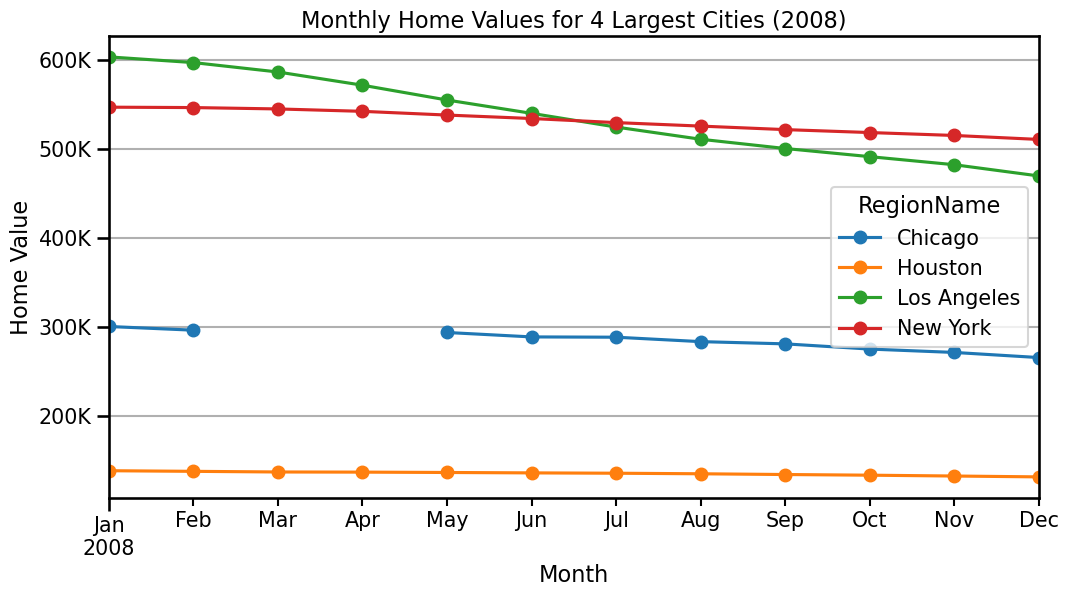

In [13]:
# Plot the home values for all 4 citiesw (using unstack)
ax = monthly_data.unstack('RegionName')['2008-01':'2008-12'].plot(figsize=(12,6), 
                                                                  marker='o')

# Add a title and axis labels
ax.set_title('Monthly Home Values for 4 Largest Cities (2008)')
ax.set_xlabel('Month')
ax.set_ylabel('Home Value')

# Reformat the y-axis ticks to use thousands of dollars with a "K" at the end
def thousands(x, pos):
    'The two args are the value and tick position'
    return f'{int(x/1000)}K'
formatter = mtick.FuncFormatter(thousands)
ax.yaxis.set_major_formatter(formatter)

# Show the plot
plt.grid()
plt.show()

### Questions

Answer the following 2 questions using pandas:

1) Which City had the highest Typical Home Value at the end of 2008? Which had the least?
    - Hint: You can use the unstacked dataframe or use pd.IndexSlice with the multiindex. 

In [14]:
# Unstack the data to have cities as columns
unstacked_data = monthly_data.unstack('RegionName')

In [15]:
# Get the home values at the end of 2008 (December 2008)
home_vals_dec_2008 = unstacked_data.loc['2008-12-31']

In [16]:
# Find the city with the highest and least typical home values
highest_val_city = home_vals_dec_2008.idxmax()
least_val_city = home_vals_dec_2008.idxmin()

print(f"The city with the highest typical home value at the end of 2008: {highest_val_city}")
print(f"The city with the least typical home value at the end of 2008: {least_val_city}")

The city with the highest typical home value at the end of 2008: New York
The city with the least typical home value at the end of 2008: Houston


2) How much did the home values change from November 2008 to December 2008 (in dollars)?
    - Hint: you can use .diff() to calculate the change in values

In [17]:
# Calculate the monthly change in home values using .diff()
monthly_change = monthly_data.diff()

In [18]:
# Get the change in home values from November 2008
home_vals_nov_2008 = unstacked_data.loc['2008-11-30']

In [19]:
# Get the change in home values from November 2008 to December 2008
nov_to_dec_change = home_vals_dec_2008 - home_vals_nov_2008

print(f"The change in home values from November 2008 to December 2008:")
print(nov_to_dec_change)

The change in home values from November 2008 to December 2008:
RegionName
Chicago        -5753.0
Houston         -964.0
Los Angeles   -12611.0
New York       -4458.0
dtype: float64
